In [1]:
import os
os.chdir("../")

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt

In [3]:
import constants

In [4]:
from src.preprocess.feature_extractor import FeatureExtractor
from src.preprocess.target_processor import TargetProcessor

In [5]:
TEXT_COLOR = '#313131'
# Plotly colors
LINE_COLORS = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

sns.set(
    style='darkgrid', 
    rc={'figure.figsize':(6,4),
        'figure.dpi': 100,
        'figure.facecolor': 'w', 
        'legend.facecolor': 'w',
        'text.color': TEXT_COLOR,
        'font.family': 'Microsoft Sans Serif', # 'Open Sans',
        'axes.labelcolor': TEXT_COLOR,
        'xtick.color': TEXT_COLOR,
        'ytick.color': TEXT_COLOR}
)

sns.set_palette(sns.color_palette(LINE_COLORS))

# Extract features

In [6]:
SAMPLE_WAV_PATH = "data/audio/22_guillem.wav"

In [7]:
feature_extractor = FeatureExtractor()

In [8]:
%%time
x = feature_extractor.process_file(SAMPLE_WAV_PATH)

Sample rate from 48000 to 8000.


CPU times: user 4.52 s, sys: 928 ms, total: 5.44 s
Wall time: 2.51 s


---

# Build targets

Convert start & end seconds into % contamination per frame

In [9]:
target_processor = TargetProcessor()

In [10]:
path = "data/labels/parsed_annotations/1_ines.csv"

In [11]:
y = target_processor.process(path, size=x.shape[1])

---

In [12]:
TRAIN_SPEAKERS = [
    "1_ines", 
    "2_helena",
    "3_ignasi",
    "4_sonia",
    "5_david",
    "6_gloria",
    "8_diana",
    "9_daniel",
    "10_oriol", 
    "13_tomy",
    "14_maria", 
    "15_arancha",
    "16_tropicfeel",
    "17_robert",
    # "18_lourdes", 
    # "19_pablo",
    "20_anna",
    "21_eirene",
    "22_patricia",
    "23_carlos",
    "25_daniel",
    "26_angel",
    "27_angela",
    "28_joachim",
    "29_alfredo",
]

In [13]:
TEST_SPEAKERS = [
    "30_segolene",
    "31_andrew",
    "32_alexia",
    "33_bernat",
    "34_bernat",
    "33_jon",
    "35_juanjo",
    "36_clara",
    "37_sandra",
]

In [14]:
feature_extractor = FeatureExtractor()
target_processor = TargetProcessor()

In [31]:
data_folder = "data/"

x_train = torch.Tensor([])
y_train = torch.Tensor([])

for speaker in TRAIN_SPEAKERS[:2]:
    audio_path = f"data/audio/{speaker}.wav"
    annotation_path = f"data/labels/parsed_annotations/{speaker}.csv"
    
    current_x = feature_extractor.process_file(audio_path)
    current_y = target_processor.process(annotation_path, size=current_x.shape[1])
    
    x_train = torch.concat((x_train, current_x), dim=1)
    y_train = torch.concat((y_train, current_y), dim=0)

Sample rate from 48000 to 8000.
Sample rate from 48000 to 8000.


In [32]:
x_train.shape

torch.Size([40, 26112])

In [33]:
y_train.shape

torch.Size([26112])

### Understand the dataset

In [34]:
y = y_train.clone()

In [35]:
# Convert to binary
threshold = 0.8
y[y>=threshold] = 1
y[y<threshold] = 0

Text(0.5, 1.0, 'Target distribution is very imbalanced')

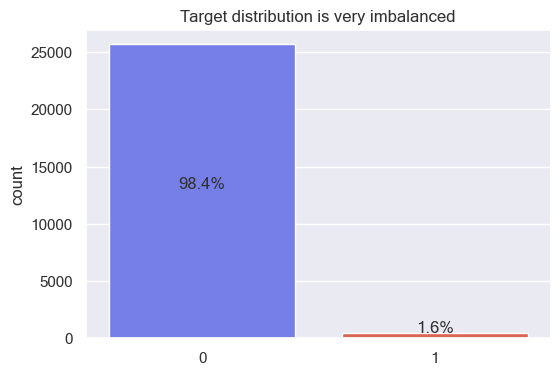

In [36]:
fig,ax = plt.subplots()
sns.countplot(x=y.numpy().astype(int), ax=ax)

# show the mean
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    pct = 100 * h / y.shape[0]
    text = f'{pct:0.1f}%'
    ax.annotate(text=text, xy=xy, ha='center', va='bottom')
    
plt.title("Target distribution is very imbalanced")

---

In [37]:
seconds_per_frame = constants.HOP_LENGTH / constants.SAMPLE_RATE

/var/folders/q_/10kbwhdx04lc4nptpgk0fklm0000gp/T/ipykernel_3362/4033836094.py:19: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0].get_shared_x_axes().join(axs[0], axs[1])


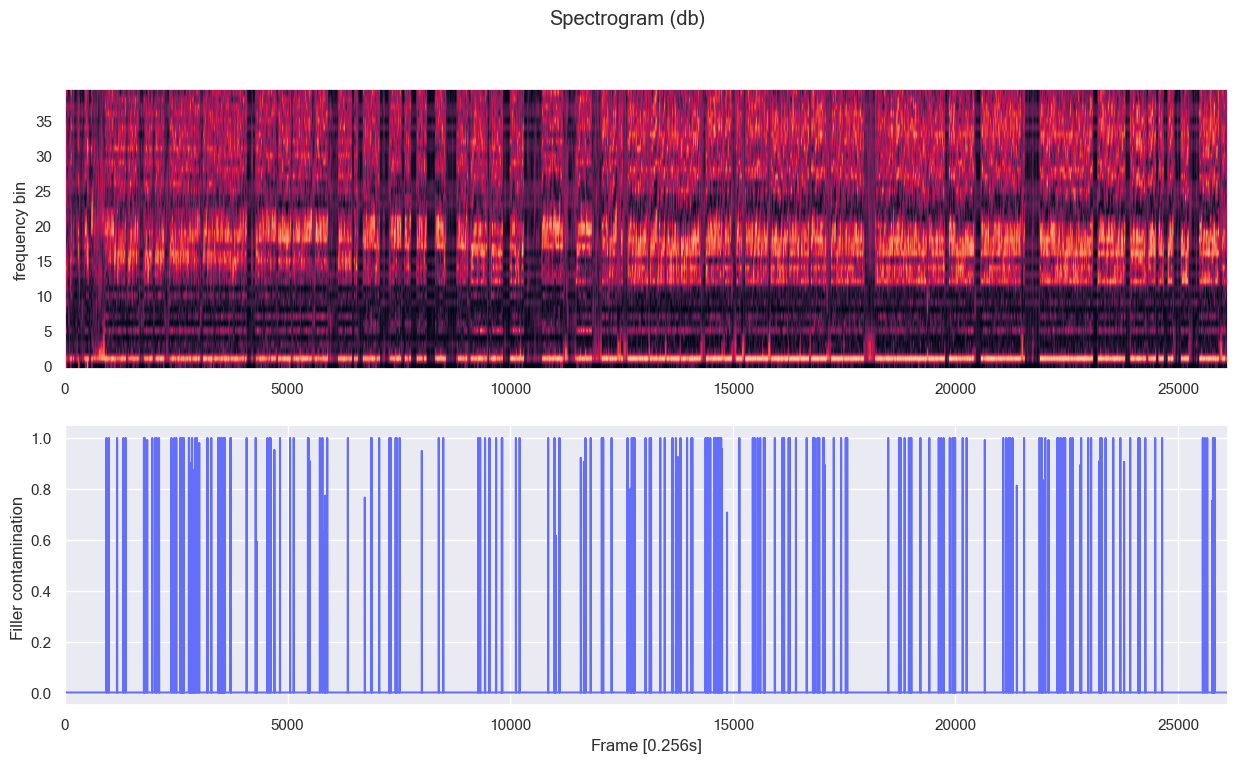

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,8))
fig.suptitle("Spectrogram (db)")

# Plot spectrogram
axs[0].imshow(
    F.amplitude_to_DB(x_train, multiplier=10., amin=0., db_multiplier=20., top_db=80.),
    origin='lower',
    aspect="auto"
)
axs[0].set_ylabel("frequency bin")
axs[0].grid(False)

# Plot targets
axs[1].plot(y_train)
axs[1].set_ylabel("Filler contamination")
axs[1].set_xlabel(f"Frame [{seconds_per_frame}s]")

# Plot
axs[0].get_shared_x_axes().join(axs[0], axs[1])
plt.show(block=False)

---

### Plot the labels

In [41]:
waveform = feature_extractor.load_audio(audio_path)

In [42]:
waveform = feature_extractor.resample(waveform, new_sample_rate=8000)

Sample rate from 48000 to 8000.


/var/folders/q_/10kbwhdx04lc4nptpgk0fklm0000gp/T/ipykernel_3362/3324624114.py:21: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0].get_shared_x_axes().join(axs[0], axs[1])


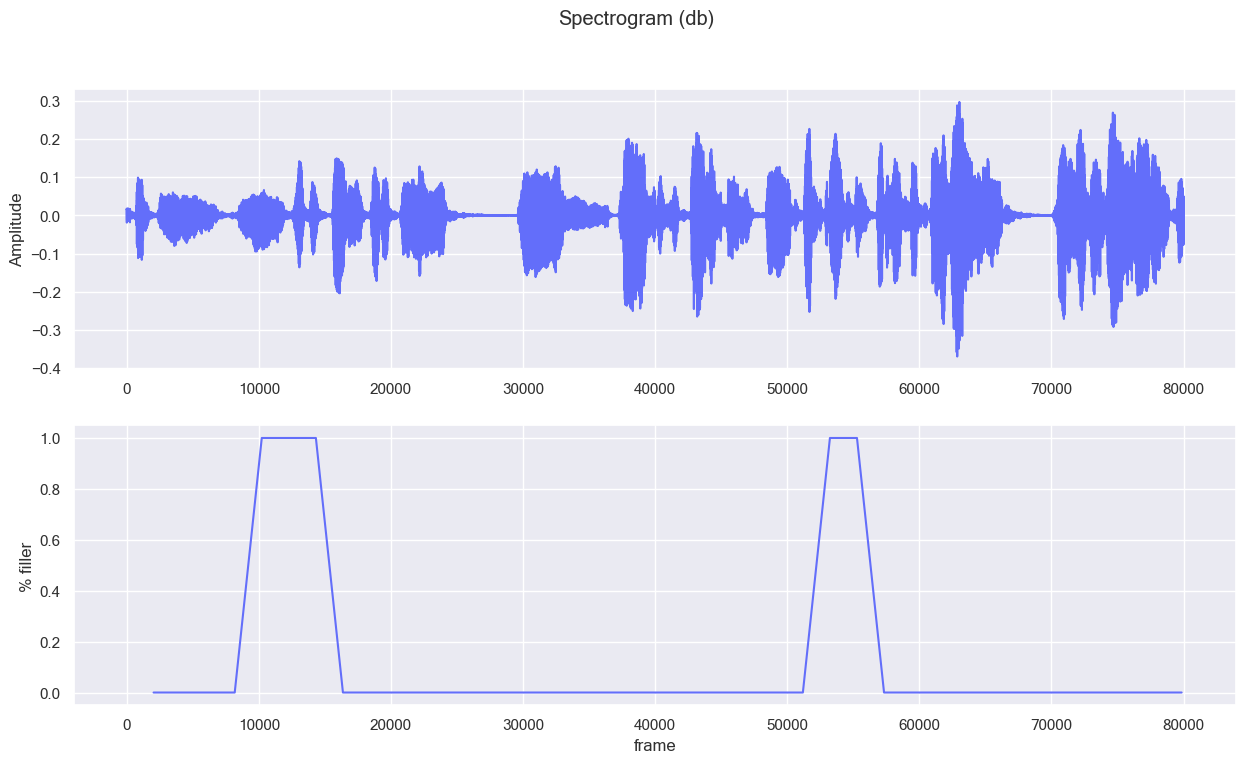

In [43]:
step = 80000
start = int(1e7 * 0.529)
end = int(start + step)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,8))
fig.suptitle("Spectrogram (db)")

# Plot audio waveform
axs[0].plot(waveform.t().numpy()[start:end])
axs[0].set_ylabel("Amplitude")

# Plot targets
x_plot = (np.arange(0, y.shape[0]) * constants.HOP_LENGTH)
mask = (x_plot >= start) & (x_plot < end)
axs[1].plot(x_plot[mask] - start, y[mask])

axs[1].set_xlabel("frame")
axs[1].set_ylabel("% filler")

# Plot
axs[0].get_shared_x_axes().join(axs[0], axs[1])
plt.show(block=False)

---

### Train baseline model: RandomForest

In [50]:
from sklearn.ensemble import RandomForestClassifier

ModuleNotFoundError: No module named 'sklearn'

In [48]:
x_train.numpy()

array([[-3.4556360e+02, -3.3669592e+02, -3.4346860e+02, ...,
        -3.7695554e+02, -3.8063779e+02, -2.5940417e+02],
       [ 1.6325528e-05, -8.0143776e+00,  4.5179093e-01, ...,
         1.0780056e+00,  4.5439625e-01, -3.5143913e+01],
       [-8.3309233e-06, -2.2713170e+00, -2.2210164e+00, ...,
        -5.0450559e+00,  3.8791227e-01, -1.3188791e-01],
       ...,
       [ 3.7670135e-05, -1.1340395e+00,  5.8884823e-01, ...,
        -6.4014471e-01,  1.3754368e-01, -8.6824608e+00],
       [-9.8425247e-05, -1.0322144e+00, -1.7861935e-01, ...,
        -2.8266382e+00,  1.9910455e-01,  3.8333666e+00],
       [-8.4638596e-05,  2.0140476e+00, -1.2124014e-01, ...,
        -4.1025400e-01,  2.3717618e-01,  1.1555543e+00]], dtype=float32)

In [49]:
y_train.numpy()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
model = 

---